Used in the implementation chapter to illustrate warp per shift optimizations

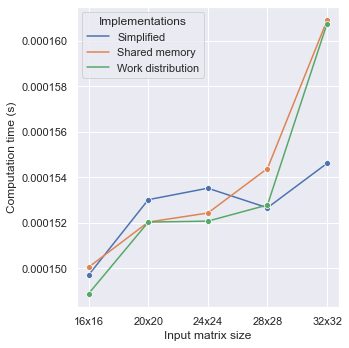

In [101]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

presentable_names = {
    "per_warp_orig": "Simplified",
    "per_warp_shared_mem": "Shared memory",
    "per_warp_work_dist": "Work distribution"
}

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "block_per_shift")

data = pd.concat([run.data for run in benchmark.groups["one_to_one"].runs], axis=0, ignore_index=True)

data = data[(data["Name"] != "per_block") & (data["Name"] != "orig")]
data = data[data["Input matrix rows"] <= 32]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])
compute_times = grouped["Computation"].mean() / 1e9
compute_times.name = "Compute time"
results = compute_times.reset_index().sort_values("Compute time")

alg_mins = results.groupby(["Name", "Input matrix rows"])["Compute time"].min().to_frame("Compute time")

alg_mins = alg_mins.reset_index()
alg_mins["Implementations"] = alg_mins["Name"].map(presentable_names)

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=alg_mins, x="Input matrix rows", y="Compute time", hue="Implementations", marker='o', ax=ax)

ax.set_xticks(alg_mins["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]

ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel("Computation time (s)")
fig.tight_layout()
fig.savefig("warp_per_shift_work_dist_local_results.svg", format="svg")

Used in implementation chapter to illustrate block per shift

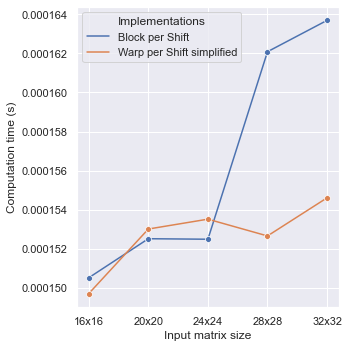

In [102]:


import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

presentable_names = {
    "orig": "Bali original",
    "per_block": "Block per Shift",
    "per_warp_orig": "Warp per Shift simplified",
    "per_warp_shared_mem": "Warp per Shift shared memory",
    "per_warp_work_dist": "Warp per Shift work distribution"
}

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "block_per_shift")

data = pd.concat([run.data for run in benchmark.groups["one_to_one"].runs], axis=0, ignore_index=True)
data = data[(data["Name"] != "per_warp_shared_mem") & (data["Name"] != "per_warp_work_dist") & (data["Name"] != "orig")]
data = data[data["Input matrix rows"] <= 32]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])
compute_times = grouped["Computation"].mean() / 1e9
compute_times.name = "Compute time"
results = compute_times.reset_index().sort_values("Compute time")

alg_mins = results.groupby(["Name", "Input matrix rows"])["Compute time"].min().to_frame("Compute time")

alg_mins = alg_mins.reset_index()
alg_mins["Implementations"] = alg_mins["Name"].map(presentable_names)

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=alg_mins, x="Input matrix rows", y="Compute time", hue="Implementations", marker='o', ax=ax)

ax.set_xticks(alg_mins["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel("Computation time (s)")
fig.tight_layout()
fig.savefig("block_per_shift_local_results.svg", format="svg")

FFT dependency on precise input size from GPU lab

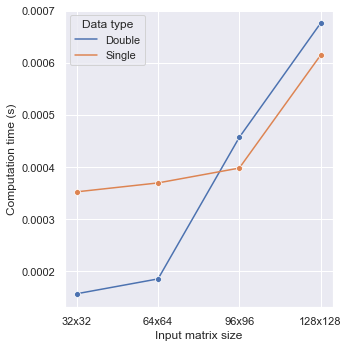

In [105]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from shared import Benchmark, Run, Group


from pathlib import Path
from typing import List, Tuple, Dict, Any

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_gpulab")

groups = {
    "single_one_to_one_computate": "Single",
    "double_one_to_one_compute": "Double",
}


data = pd.concat([run.data for run in itertools.chain.from_iterable([benchmark.groups[group_name].runs for group_name in groups.keys()])], axis=0, ignore_index=True)

data = data[data["Input matrix rows"] <= 128]

grouped = data.groupby(["Group", "Input matrix rows"])
compute_times = grouped["Computation"].mean() / 1e9
compute_times.name = "Compute time"
results = compute_times.reset_index().sort_values("Compute time")

results["Data type"] = results.apply(lambda row: groups[row["Group"]], axis=1)

# palette = dict(zip(results["Data type"].unique(), sns.color_palette(n_colors=results["Data type"].nunique())))

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Compute time", hue="Data type", marker='o', ax=ax)

ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks)
ax.set_xlabel("Input matrix size")
ax.set_ylabel("Computation time (s)")
fig.tight_layout()
fig.savefig("fft_small_compute_time.svg", format="svg")

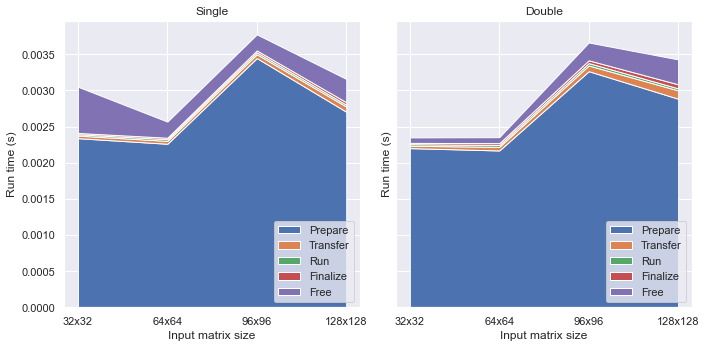

In [106]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from shared import Benchmark, Run, Group


from pathlib import Path
from typing import List, Tuple, Dict, Any

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_gpulab")

steps = ["Prepare", "Transfer", "Run", "Finalize", "Free"]

groups = ["single_one_to_one_steps", "double_one_to_one_steps"]

data = pd.concat([run.data for run in itertools.chain.from_iterable([benchmark.groups[group_name].runs for group_name in groups])], axis=0, ignore_index=True)

data = data[data["Input matrix rows"] <= 128]

grouped = data.groupby(["Group", "Input matrix rows"])

results = grouped[steps[0]].mean() / 1e9
results.name = steps[0]
results = results.to_frame()
for step in steps[1:]:
    step_time = grouped[step].mean() / 1e9
    step_time.name = step
    results = results.join(step_time.to_frame())

results = results.reset_index().sort_values("Input matrix rows")


sns.set(rc={'figure.figsize': (10, 5)})
sns.set_theme()
fig, axs = plt.subplots(ncols=2, sharey=True)

for idx, group in enumerate(groups):
    ax = axs[idx]
    group_data = results[results["Group"] == group]
    ax.stackplot(group_data["Input matrix rows"], *[group_data[step] for step in steps], labels=steps)

    ax.set_xticks(group_data["Input matrix rows"].unique())
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel("Run time (s)")
    ax.legend(loc="lower right")
    ax.set_title(["Single", "Double"][idx])
fig.tight_layout()
fig.savefig("fft_small_step_time.svg", format="svg")

# FFT with more measurements in the small size range

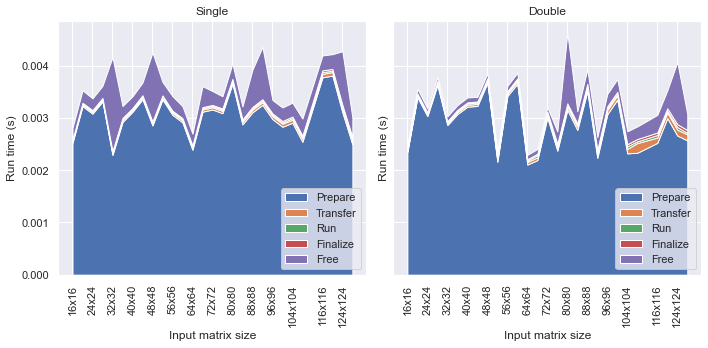

In [108]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from shared import Benchmark, Run, Group


from pathlib import Path
from typing import List, Tuple, Dict, Any

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_small_gpulab")

steps = ["Prepare", "Transfer", "Run", "Finalize", "Free"]

groups = ["single_one_to_one_steps", "double_one_to_one_steps"]

data = pd.concat([run.data for run in itertools.chain.from_iterable([benchmark.groups[group_name].runs for group_name in groups])], axis=0, ignore_index=True)

data = data[data["Input matrix rows"] <= 128]

grouped = data.groupby(["Group", "Input matrix rows"])

results = grouped[steps[0]].mean() / 1e9
results.name = steps[0]
results = results.to_frame()
for step in steps[1:]:
    step_time = grouped[step].mean() / 1e9
    step_time.name = step
    results = results.join(step_time.to_frame())

results = results.reset_index().sort_values("Input matrix rows")


sns.set(rc={'figure.figsize': (10, 5)})
sns.set_theme()
fig, axs = plt.subplots(ncols=2, sharey=True)

for idx, group in enumerate(groups):
    ax = axs[idx]
    group_data = results[results["Group"] == group]
    ax.stackplot(group_data["Input matrix rows"], *[group_data[step] for step in steps], labels=steps)
    ax.set_xticks(group_data["Input matrix rows"].unique()[::2])
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel("Run time (s)")
    ax.legend(loc="lower right")
    ax.set_title(["Single", "Double"][idx])
fig.tight_layout()
fig.savefig("fft_small_step_time.svg", format="svg")

# GPULAB ONE TO ONE WARP SHUFFLE SPEEDUP

Multirow right max slowdown: 67.84482000069056%
Multirow both max slowdown: 30.56348014135175%
                                            Name Args  Input matrix rows  \
19  nai_shuffle_multimat_right_work_distribution                      16   
20  nai_shuffle_multimat_right_work_distribution                      32   
21  nai_shuffle_multimat_right_work_distribution                      64   
22  nai_shuffle_multimat_right_work_distribution                      96   
23  nai_shuffle_multimat_right_work_distribution                     128   
24  nai_shuffle_multimat_right_work_distribution                     160   
25  nai_shuffle_multimat_right_work_distribution                     192   
43                     nai_shuffle_multirow_both    8                224   
44                     nai_shuffle_multirow_both    8                256   
45                     nai_shuffle_multirow_both    8                288   
46                     nai_shuffle_multirow_both    8                

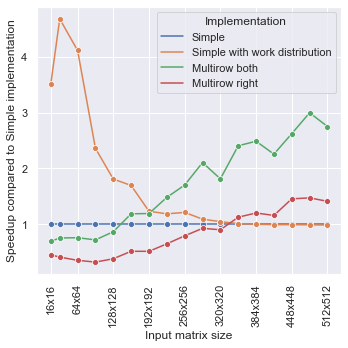

In [109]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_one"]

comparison_base_name = "nai_shuffle_multimat_right"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_multimat_right": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Simple with work distribution",
    },
    "nai_shuffle_multirow_right": {
        # "4": "Multirow right with 4 overlaps",
        # "8": "Multirow right with 8 overlaps",
        "8": "Multirow right"
    },
    "nai_shuffle_multirow_both": {
        # "4": "Multirow both with 4 overlaps",
        # "8": "Multirow both with 8 overlaps"
        "8": "Multirow both"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])



kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

results = results[results["Input matrix rows"] <= 512 ]




sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique()[::2])
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()
fig.savefig("warp_shuffle_one_to_one_gpulab.svg", format="svg")

multirow_right_min_speedup = results[(results["Name"] == "nai_shuffle_multirow_right") & (results["Args"] == "8")]["Speedup"].min()
print(f"Multirow right max slowdown: {(1 - multirow_right_min_speedup)*100}%")
multirow_both_min_speedup = results[(results["Name"] == "nai_shuffle_multirow_both") & (results["Args"] == "8")]["Speedup"].min()
print(f"Multirow both max slowdown: {(1 - multirow_both_min_speedup)*100}%")


max_speedup = results.groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()
min_speedup = results.groupby(["Input matrix rows"])["Speedup"].min().to_frame().reset_index()

print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(min_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])

# GPULAB ONE TO MANY WARP SHUFFLE SPEEDUP

                                        Name Args  Input right matrices  \
95  nai_shuffle_multirow_both_multimat_right                       1024   
96  nai_shuffle_multirow_both_multimat_right                       1024   
97  nai_shuffle_multirow_both_multimat_right                       1024   
98  nai_shuffle_multirow_both_multimat_right                       1024   
99  nai_shuffle_multirow_both_multimat_right                       1024   

    Input matrix rows  Kernel time   Speedup                Implementation  
95                 32     0.000632  3.132199  Multirow both multimat right  
96                 64     0.006386  3.663672  Multirow both multimat right  
97                128     0.079751  3.880780  Multirow both multimat right  
98                256     1.110311  4.002985  Multirow both multimat right  
99                512    16.835558  3.983799  Multirow both multimat right  
                Name Args  Input right matrices  Input matrix rows  \
20  nai_shuffle_b

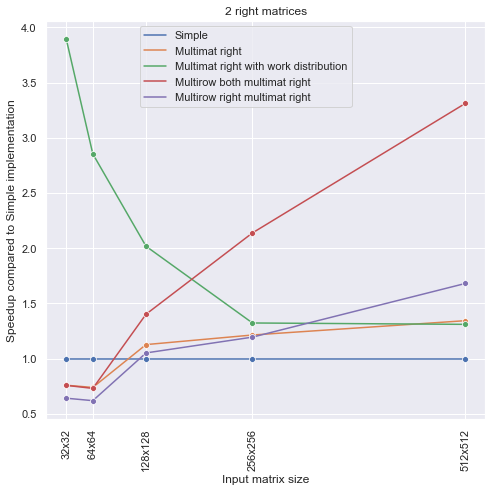

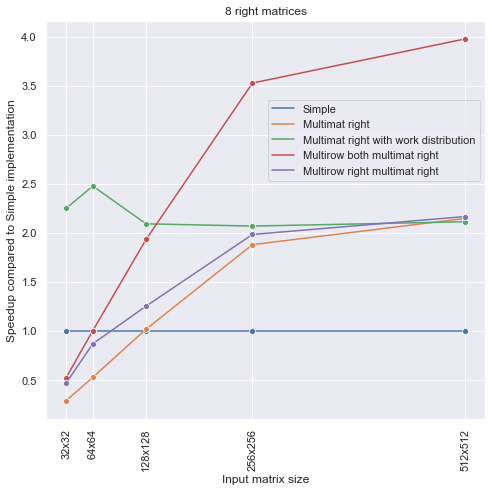

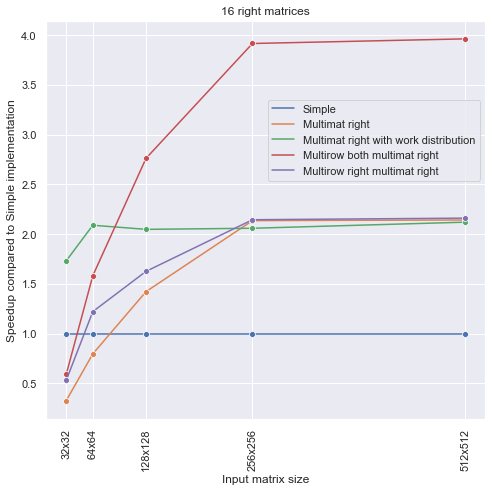

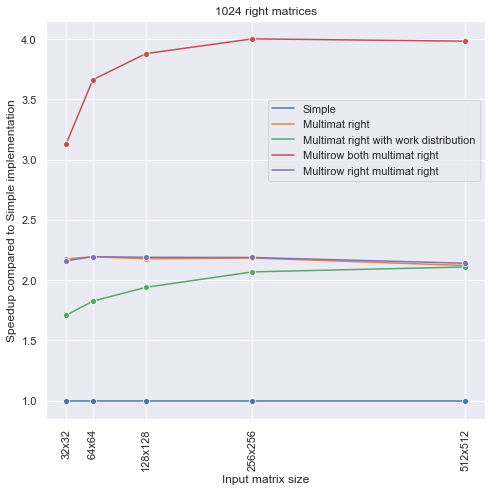

In [110]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict, Optional

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_many"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right": {
        # "2": "Multimat right with 2 matrices",
        # "8": "Multimat right with 8 matrices"
        "8": "Multimat right"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multirow_right_multimat_right": {
        "": "Multirow right multimat right"
    },
    "nai_shuffle_multirow_both_multimat_right": {
        "": "Multirow both multimat right"
    },
    # "nai_warp_per_shift_shared_mem": {
    #     "": "Warp per shift with shared memory"
    # },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (7, 7)})


def plot(data: pd.DataFrame, right_matrices: int, path: Path, diagram_properties = None):
    fig, ax = plt.subplots()
    r_mat_results = data[data["Input right matrices"] == right_matrices]
    ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ax.set_xticks(r_mat_results["Input matrix rows"].unique())
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{right_matrices} right matrices")
    if diagram_properties is not None and "legend" in diagram_properties:
        ax.legend(**diagram_properties["legend"])
    fig.tight_layout()
    fig.savefig(path, format="svg")
    if diagram_properties.get("absolute_times", False):
        max_speedup = r_mat_results.groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()
        min_speedup = r_mat_results.groupby(["Input matrix rows"])["Speedup"].min().to_frame().reset_index()

        print(r_mat_results[r_mat_results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
        print(r_mat_results[r_mat_results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(min_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])

diagrams = {
    2: {
        "legend": {
            "bbox_to_anchor": (0.2, 1),
        }
    },
    8: {
        "legend": {
            "bbox_to_anchor": (1, 0.7),
            "loc": "center right"
        }
    },
    16: {
        "legend": {
            "bbox_to_anchor": (1, 0.7),
            "loc": "center right"
        }
    },
    1024: {
        "legend": {
            "bbox_to_anchor": (1, 0.7),
            "loc": "center right"
        },
        "absolute_times": True,
    }
}

for right_matrices, legend_anchor in diagrams.items():
    plot(results, right_matrices, Path(f"warp_shuffle_one_to_many_{right_matrices}_matrices_gpulab.svg"), legend_anchor)

# GPULAB N TO MN WARP SHUFFLE SPEEDUP

                                        Name Args  Input left matrices  \
90  nai_shuffle_multirow_both_multimat_right                       100   
91  nai_shuffle_multirow_both_multimat_right                       100   
92  nai_shuffle_multirow_both_multimat_right                       100   
93  nai_shuffle_multirow_both_multimat_right                       100   
94  nai_shuffle_multirow_both_multimat_right                       100   

    Input right matrices  Input matrix rows  Kernel time   Speedup  \
90                  1000                 32     0.000901  2.189655   
91                  1000                 64     0.006909  3.314199   
92                  1000                128     0.082959  3.638641   
93                  1000                256     1.129813  3.837598   
94                  1000                512    17.290161  3.784436   

                  Implementation  
90  Multirow both multimat right  
91  Multirow both multimat right  
92  Multirow both multimat ri

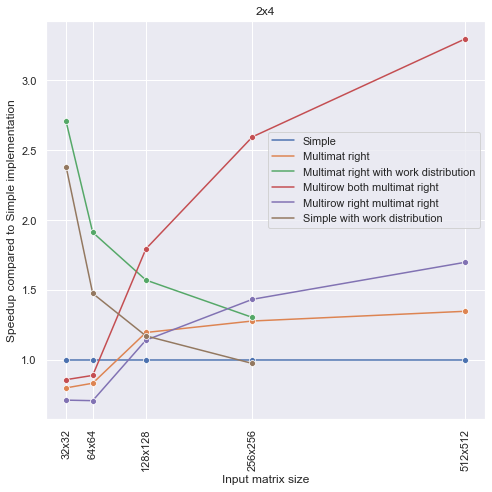

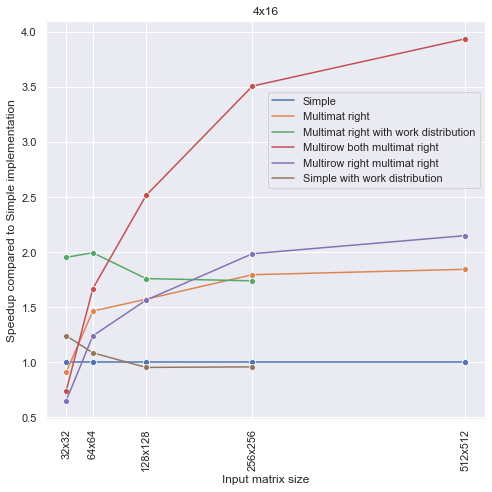

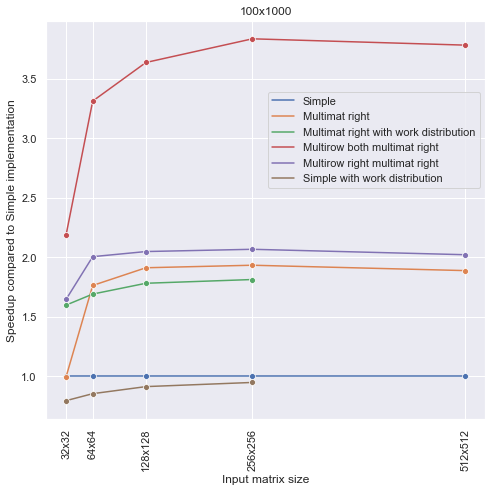

In [111]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_mn"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_work_distribution": {
        "": "Simple with work distribution"
    },
    "nai_shuffle_multimat_right": {
        "": "Multimat right"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multirow_right_multimat_right": {
        "": "Multirow right multimat right"
    },
    "nai_shuffle_multirow_both_multimat_right": {
        "": "Multirow both multimat right"
    },
    # "nai_warp_per_shift_shared_mem": {
    #     "": "Warp per shift with shared memory"
    # },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input left matrices"] == row["Input left matrices"]) &(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (7, 7)})

def plot(data: pd.DataFrame, num_matrices: Tuple[int, int], path: Path, diagram_properties = None):
    fig, ax = plt.subplots()
    mat_results = data[(data["Input left matrices"] == num_matrices[0]) & (data["Input right matrices"] == num_matrices[1])]
    ax = sns.lineplot(data=mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ax.set_xticks(mat_results["Input matrix rows"].unique())
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{num_matrices[0]}x{num_matrices[1]}")
    if diagram_properties is not None and "legend" in diagram_properties:
        ax.legend(**diagram_properties["legend"])
    fig.tight_layout()
    fig.savefig(path, format="svg")
    if diagram_properties.get("absolute_times", False):
        max_speedup = mat_results.groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()
        min_speedup = mat_results.groupby(["Input matrix rows"])["Speedup"].min().to_frame().reset_index()

        print(mat_results[mat_results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
        print(mat_results[mat_results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(min_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])

diagrams = {
    (2, 4): {
        "legend": {
            "bbox_to_anchor": (1, 0.6),
            "loc": "center right"
        }
    },
    (4, 16): {
        "legend": {
            "bbox_to_anchor": (1, 0.7),
            "loc": "center right"
        }
    },
    (100, 1000): {
        "legend": {
            "bbox_to_anchor": (1, 0.7),
            "loc": "center right"
        },
        "absolute_times": True
    },
}

for num_matrices, diagram_properties  in diagrams.items():
    plot(results, num_matrices, Path(f"warp_shuffle_n_to_mn_{num_matrices[0]}_{num_matrices[1]}_gpulab.svg"), diagram_properties)


# GPULAB N TO M WARP SHUFFLE SPEEDUP

                                              Name Args  Input left matrices  \
135  nai_shuffle_multirow_both_multimat_both_large                        50   
136  nai_shuffle_multirow_both_multimat_both_large                        50   
137  nai_shuffle_multirow_both_multimat_both_large                        50   
138  nai_shuffle_multirow_both_multimat_both_large                        50   
139  nai_shuffle_multirow_both_multimat_both_large                        50   

     Input right matrices  Input matrix rows  Kernel time   Speedup  \
135                    50                 32     0.001279  3.796327   
136                    50                 64     0.012726  4.488454   
137                    50                128     0.154506  4.892134   
138                    50                256     2.137665  5.077920   
139                    50                512    31.668288  5.177386   

                  Implementation  
135  Multirow both multimat both  
136  Multirow both mul

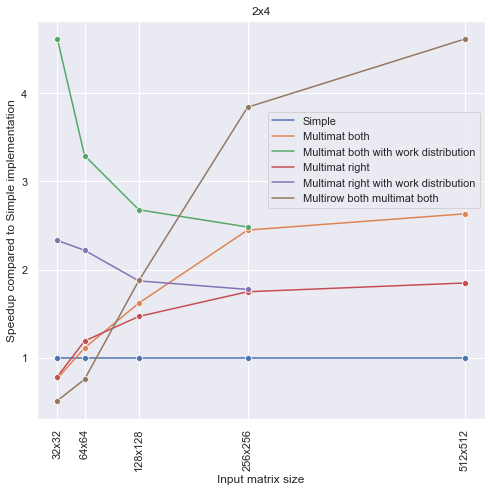

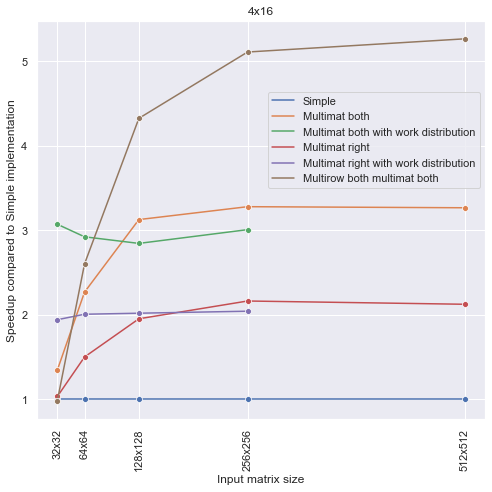

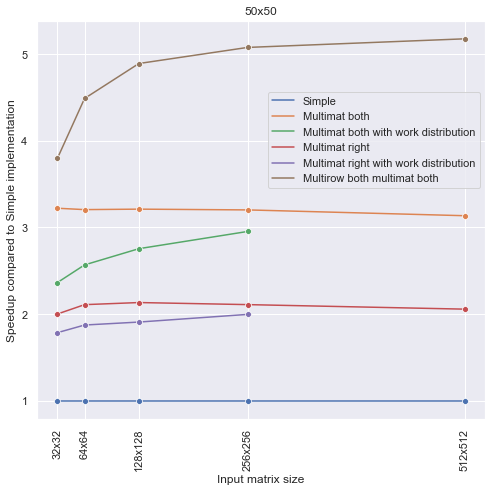

In [112]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_m"]

comparison_base_name = "nai_shuffle_base"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    # "basic": {
    #     "": "Basic",
    # },
    "nai_shuffle_base": {
        "": "Simple",
    },
    "nai_shuffle_multimat_right": {
        "": "Multimat right"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution"
    },
    "nai_shuffle_multimat_both": {
        "": "Multimat both"
    },
    "nai_shuffle_multimat_both_work_distribution": {
        "": "Multimat both with work distribution"
    },
    # "nai_shuffle_multirow_both_multimat_both": {
    #     "": "Multirow both multimat both with 2 2"
    # },
    "nai_shuffle_multirow_both_multimat_both_large": {
        "": "Multirow both multimat both"
    },
    # "nai_warp_per_shift_shared_mem": {
    #     "": "Warp per shift with shared memory"
    # },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]

data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input left matrices", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input left matrices"] == row["Input left matrices"]) &(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]

results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (7, 7)})

def plot(data: pd.DataFrame, num_matrices: Tuple[int, int], path: Path, diagram_properties = None):
    fig, ax = plt.subplots()
    mat_results = data[(data["Input left matrices"] == num_matrices[0]) & (data["Input right matrices"] == num_matrices[1])]
    ax = sns.lineplot(data=mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ax.set_xticks(mat_results["Input matrix rows"].unique())
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel(f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{num_matrices[0]}x{num_matrices[1]}")
    if diagram_properties is not None and "legend" in diagram_properties:
        ax.legend(**diagram_properties["legend"])
    fig.tight_layout()
    fig.savefig(path, format="svg")
    if diagram_properties.get("absolute_times", False):
        max_speedup = mat_results.groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()
        min_speedup = mat_results.groupby(["Input matrix rows"])["Speedup"].min().to_frame().reset_index()

        print(mat_results[mat_results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
        print(mat_results[mat_results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(min_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])

diagrams = {
    (2, 4): {
        "legend": {
            "bbox_to_anchor": (1, 0.65),
            "loc": "center right"
        }
    },
    (4, 16): {
        "legend": {
            "bbox_to_anchor": (1, 0.7),
            "loc": "center right"
        }
    },
    (50, 50): {
        "legend": {
            "bbox_to_anchor": (1, 0.7),
            "loc": "center right"
        },
        "absolute_times": True
    },
}

for num_matrices, diagram_properties in diagrams.items():
    plot(results, num_matrices, Path(f"warp_shuffle_n_to_m_{num_matrices[0]}_{num_matrices[1]}_gpulab.svg"), diagram_properties)


# GPULAB WARP PER SHIFT SPEEDUP

                             Name Args  Input matrix rows  Kernel time  \
20             nai_warp_per_shift                      16     0.000004   
24             nai_warp_per_shift                      32     0.000008   
45  nai_warp_per_shift_shared_mem                      64     0.000049   
46  nai_warp_per_shift_shared_mem                      96     0.000169   
47  nai_warp_per_shift_shared_mem                     128     0.000442   
48  nai_warp_per_shift_shared_mem                     160     0.000953   
49  nai_warp_per_shift_shared_mem                     192     0.001820   
50  nai_warp_per_shift_shared_mem                     224     0.003171   
51  nai_warp_per_shift_shared_mem                     256     0.005183   
52  nai_warp_per_shift_shared_mem                     288     0.008199   
53  nai_warp_per_shift_shared_mem                     320     0.012274   
54  nai_warp_per_shift_shared_mem                     352     0.017673   
55  nai_warp_per_shift_shared_mem     

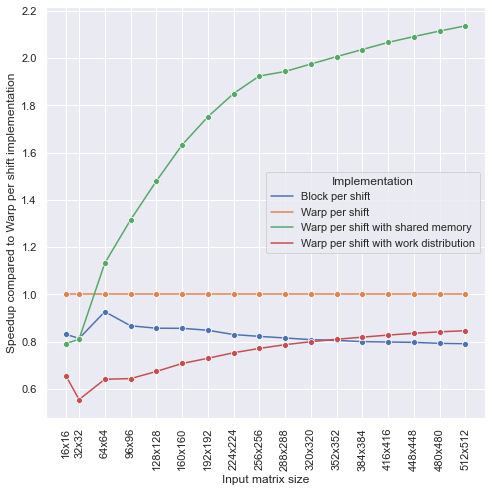

In [113]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_per_shift_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_one"]

comparison_base_name = "nai_warp_per_shift"
comparison_base_args = ""
algs_and_args = {
    "nai_warp_per_shift": {
        "": "Warp per shift",
    },
    "nai_warp_per_shift_work_distribution": {
        "": "Warp per shift with work distribution",

    },
    "nai_warp_per_shift_shared_mem": {
        "": "Warp per shift with shared memory"
    },
    "nai_block_per_shift": {
        "": "Block per shift"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)


def filter_data(row) -> bool:
    return row["Name"] in algs_and_args and row["Args"] in algs_and_args[row["Name"]]


data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]


def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]][
        "Kernel time"].item()
    return min_time / row["Kernel time"]


def map_name(row):
    return algs_and_args[row["Name"]][row["Args"]]


results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

results = results[(results["Input matrix rows"].isin([16, 32])) | (results["Input matrix rows"] >= 64)]

sns.set(rc={'figure.figsize': (7, 7)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to {algs_and_args[comparison_base_name][comparison_base_args]} implementation")
fig.tight_layout()
fig.savefig("warp_per_shift_one_to_one_gpulab.svg", format="svg")

max_speedup = results.groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()


print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
print(results[results["Name"] == "nai_warp_per_shift"])

# GPULAB ONE TO ONE DEFINITION BASED SPEEDUP

                                            Name Args  Input matrix rows  \
38  nai_shuffle_multimat_right_work_distribution                      16   
39  nai_shuffle_multimat_right_work_distribution                      32   
40  nai_shuffle_multimat_right_work_distribution                      64   
41  nai_shuffle_multimat_right_work_distribution                      96   
42  nai_shuffle_multimat_right_work_distribution                     128   
43  nai_shuffle_multimat_right_work_distribution                     160   
61                     nai_shuffle_multirow_both    4                192   
62                     nai_shuffle_multirow_both    4                224   
82                     nai_shuffle_multirow_both    8                256   
83                     nai_shuffle_multirow_both    8                288   
84                     nai_shuffle_multirow_both    8                320   
85                     nai_shuffle_multirow_both    8                352   
86          

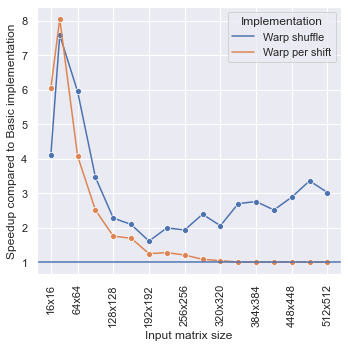

In [114]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

warp_shuffle_benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")
warp_per_shift_benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_per_shift_optimizations_speedup_gpulab2")
warp_shuffle_group = warp_shuffle_benchmark.groups["one_to_one"]
warp_per_shift_group = warp_per_shift_benchmark.groups["one_to_one"]



comparison_base_name = "basic"
comparison_base_args = ""

def get_max_speedup(group: Group):
    data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)
    grouped = data.groupby(["Name", "Args", "Input matrix rows"])



    kernel_times = grouped["Kernel"].mean() / 1e9
    kernel_times.name = "Kernel time"
    results = kernel_times.reset_index()

    comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

    def speedup(row):
        min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Kernel time"].item()
        return min_time / row["Kernel time"]


    results["Speedup"] = results.apply(speedup, axis=1)


    max_speedup = results.groupby("Input matrix rows")["Speedup"].max().to_frame().reset_index()

    print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
    print(results[results["Name"] == "basic"])

    return max_speedup

warp_shuffle_speedup = get_max_speedup(warp_shuffle_group)
warp_shuffle_speedup["Opt"] = "Warp shuffle"
warp_per_shift_speedup = get_max_speedup(warp_per_shift_group)
warp_per_shift_speedup["Opt"] = "Warp per shift"

input_sizes = [16, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512]

warp_shuffle_speedup = warp_shuffle_speedup[warp_shuffle_speedup["Input matrix rows"].isin(input_sizes)]

warp_per_shift_speedup = warp_per_shift_speedup[warp_per_shift_speedup["Input matrix rows"].isin(input_sizes)]


results = pd.concat([warp_shuffle_speedup, warp_per_shift_speedup]).reset_index()

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()



ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Opt", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique()[::2])
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
legend = ax.get_legend()
legend.set_title("Implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("definition_based_speedup_one_to_one_gpulab.svg", format="svg")



# GPULAB ONE TO MANY DEFINITION BASED SPEEDUP

                                             Name Args  Input right matrices  \
100  nai_shuffle_multimat_right_work_distribution                          2   
101  nai_shuffle_multimat_right_work_distribution                          2   
102  nai_shuffle_multimat_right_work_distribution                          2   
105  nai_shuffle_multimat_right_work_distribution                          4   
106  nai_shuffle_multimat_right_work_distribution                          4   
107  nai_shuffle_multimat_right_work_distribution                          4   
110  nai_shuffle_multimat_right_work_distribution                          8   
111  nai_shuffle_multimat_right_work_distribution                          8   
112  nai_shuffle_multimat_right_work_distribution                          8   
115  nai_shuffle_multimat_right_work_distribution                         16   
116  nai_shuffle_multimat_right_work_distribution                         16   
128      nai_shuffle_multirow_both_multi

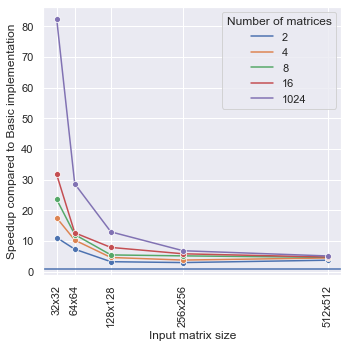

In [115]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["one_to_many"]

comparison_base_name = "basic"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

results["Speedup"] = results.apply(speedup, axis=1)


max_speedup = results.groupby(["Input matrix rows", "Input right matrices"])["Speedup"].max().to_frame().reset_index()
max_speedup.rename(columns={"Input right matrices": "Number of matrices"}, inplace=True)

palette = dict(zip(max_speedup["Number of matrices"].unique(), sns.color_palette(n_colors=max_speedup["Number of matrices"].nunique())))

print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
print(results[results["Name"] == "basic"])

sns.set(rc={'figure.figsize': (5, 5)})

fig, ax = plt.subplots()

ax = sns.lineplot(data=max_speedup, x="Input matrix rows", y="Speedup", hue="Number of matrices", marker='o', palette=palette, ax=ax)
ax.set_xticks(max_speedup["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("definition_based_speedup_one_to_many_gpulab.svg", format="svg")



# GPULAB N TO MN DEFINITION BASED SPEEDUP

                                             Name Args Input type  \
79   nai_shuffle_multimat_right_work_distribution             2x4   
80   nai_shuffle_multimat_right_work_distribution             2x4   
83   nai_shuffle_multimat_right_work_distribution             2x8   
84   nai_shuffle_multimat_right_work_distribution             2x8   
87   nai_shuffle_multimat_right_work_distribution            4x16   
88   nai_shuffle_multimat_right_work_distribution            4x16   
91   nai_shuffle_multimat_right_work_distribution             4x8   
92   nai_shuffle_multimat_right_work_distribution             4x8   
95       nai_shuffle_multirow_both_multimat_right        100x1000   
96       nai_shuffle_multirow_both_multimat_right        100x1000   
97       nai_shuffle_multirow_both_multimat_right        100x1000   
98       nai_shuffle_multirow_both_multimat_right        100x1000   
99       nai_shuffle_multirow_both_multimat_right        100x1000   
102      nai_shuffle_multirow_both

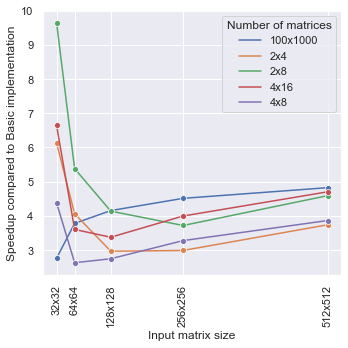

In [116]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_mn"]

comparison_base_name = "basic"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

results["Speedup"] = results.apply(speedup, axis=1)

max_speedup = results.groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
max_speedup.rename(columns={"Input type": "Number of matrices"}, inplace=True)


print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
print(results[results["Name"] == "basic"])

sns.set(rc={'figure.figsize': (5, 5)})


fig, ax = plt.subplots()
ax = sns.lineplot(data=max_speedup, x="Input matrix rows", y="Speedup", hue="Number of matrices", marker='o', ax=ax)
ax.set_xticks(max_speedup["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
fig.tight_layout()
fig.savefig("definition_based_speedup_n_to_mn_gpulab.svg", format="svg")

# GPULAB N TO M DEFINITION BASED SPEEDUP

                                              Name Args Input type  \
75     nai_shuffle_multimat_both_work_distribution             2x2   
76     nai_shuffle_multimat_both_work_distribution             2x2   
77     nai_shuffle_multimat_both_work_distribution             2x2   
79     nai_shuffle_multimat_both_work_distribution             2x4   
80     nai_shuffle_multimat_both_work_distribution             2x4   
81     nai_shuffle_multimat_both_work_distribution             2x4   
83     nai_shuffle_multimat_both_work_distribution            4x16   
87     nai_shuffle_multimat_both_work_distribution             4x2   
88     nai_shuffle_multimat_both_work_distribution             4x2   
89     nai_shuffle_multimat_both_work_distribution             4x2   
144        nai_shuffle_multirow_both_multimat_both             2x2   
151        nai_shuffle_multirow_both_multimat_both            4x16   
158        nai_shuffle_multirow_both_multimat_both             4x2   
159        nai_shuff

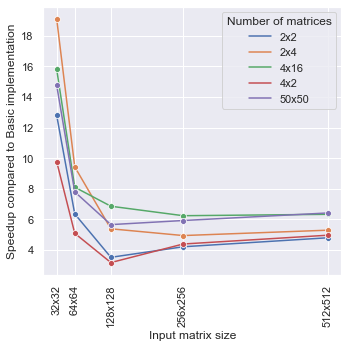

In [117]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "warp_shuffle_optimizations_speedup_gpulab")

group = benchmark.groups["n_to_m"]

comparison_base_name = "basic"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

kernel_times = grouped["Kernel"].mean() / 1e9
kernel_times.name = "Kernel time"
results = kernel_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Kernel time"].item()
    return min_time / row["Kernel time"]

results["Speedup"] = results.apply(speedup, axis=1)

max_speedup = results.groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()

max_speedup.rename(columns={"Input type": "Number of matrices"}, inplace=True)

sns.set(rc={'figure.figsize': (5, 5)})

print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(max_speedup[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
print(results[results["Name"] == "basic"])


fig, ax = plt.subplots()
ax = sns.lineplot(data=max_speedup, x="Input matrix rows", y="Speedup", hue="Number of matrices", marker='o', ax=ax)
ax.set_xticks(max_speedup["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to Basic implementation")
fig.tight_layout()
fig.savefig("definition_based_speedup_n_to_m_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP ONE TO ONE

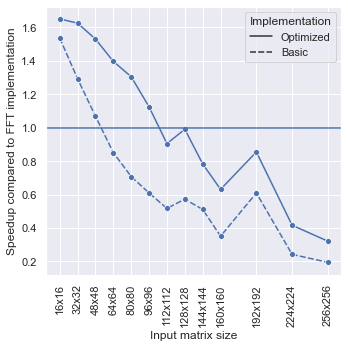

In [118]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution_gpulab")

group = benchmark.groups["one_to_one"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]



def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)

results = results[results["Input matrix rows"] <= 256]

# fft_results = results[results["Name"] == "fft_orig"].copy()
# fft_results["Implementation"] = "FFT"

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"

thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()


sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_speedup_one_to_one_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP ONE TO ONE ANTI FFT

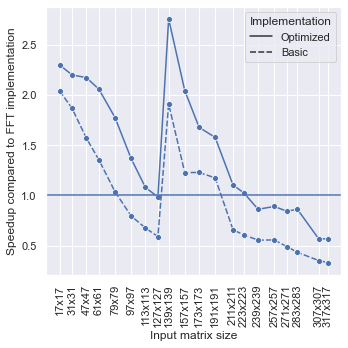

In [119]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution2_gpulab")

group = benchmark.groups["one_to_one_anti_fft"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Computation time"].item()
    return min_time / row["Computation time"]



results["Speedup"] = results.apply(speedup, axis=1)

# fft_results = results[results["Name"] == "fft_orig"].copy()
# fft_results["Implementation"] = "FFT"

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"

thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_speedup_one_to_one_anti_fft_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP ONE TO MANY

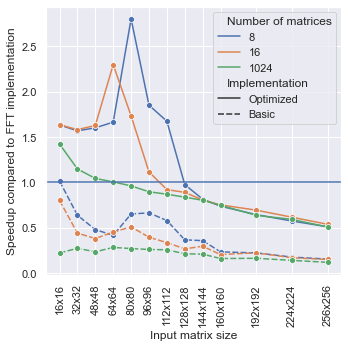

In [120]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark1 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution_gpulab")
group1 = benchmark1.groups["one_to_many"]

benchmark2 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution2_gpulab")
group2 = benchmark2.groups["one_to_many"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data1 = pd.concat([run.data for run in group1.runs], axis=0, ignore_index=True)
data2 = pd.concat([run.data for run in group2.runs], axis=0, ignore_index=True)


data = pd.concat([
    data1[~(data1["Input right matrices"].isin([2, 4]))],
    data2
], axis=0, ignore_index=True)

data = data[data["Input right matrices"] >= 8]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)
basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input right matrices"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input right matrices": "Number of matrices"}, inplace=True)
palette = dict(zip(results["Number of matrices"].unique(), sns.color_palette(n_colors=results["Number of matrices"].nunique())))

sns.set(rc={'figure.figsize': (5, 5)})

fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', palette=palette, ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_speedup_one_to_many_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP ONE TO MANY ANTIFFT

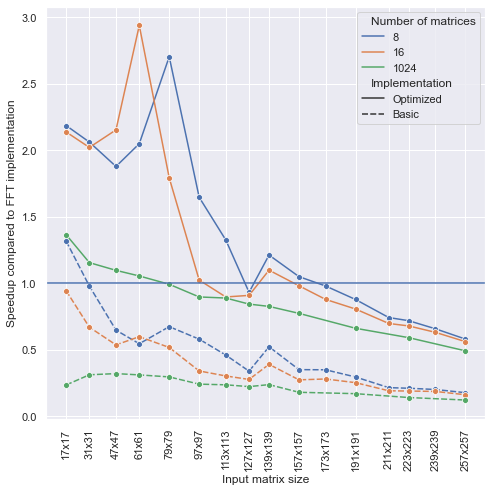

In [121]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark1 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution_gpulab")
group1 = benchmark1.groups["one_to_many_anti_fft"]

benchmark2 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution2_gpulab")
group2 = benchmark2.groups["one_to_many_anti_fft"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data1 = pd.concat([run.data for run in group1.runs], axis=0, ignore_index=True)
data2 = pd.concat([run.data for run in group2.runs], axis=0, ignore_index=True)


data = pd.concat([
    data1[~(data1["Input right matrices"].isin([2, 4, 8, 16]))],
    data2
], axis=0, ignore_index=True)

data = data[(data["Input right matrices"] >= 8) & (data["Input matrix rows"] <= 257)]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]


results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input right matrices"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input right matrices": "Number of matrices"}, inplace=True)

palette = dict(zip(results["Number of matrices"].unique(), sns.color_palette(n_colors=results["Number of matrices"].nunique())))



sns.set(rc={'figure.figsize': (7, 7)})

fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', palette=palette, ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_speedup_one_to_many_anti_fft_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP N TO MN

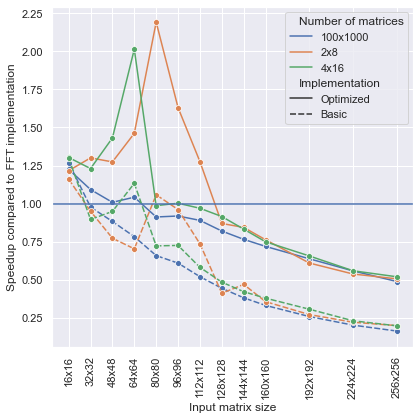

In [122]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark1 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution_gpulab")
group1 = benchmark1.groups["n_to_mn"]

benchmark2 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution2_gpulab")
group2 = benchmark2.groups["n_to_mn"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data1 = pd.concat([run.data for run in group1.runs], axis=0, ignore_index=True)
data2 = pd.concat([run.data for run in group2.runs], axis=0, ignore_index=True)


data = pd.concat([
    data1[~(data1["Input type"].isin(["2x4"]))],
    data2
], axis=0, ignore_index=True)
data = data[~(data["Input type"].isin(["2x4", "4x8"]))]

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()

results.rename(columns={"Input type": "Number of matrices"}, inplace=True)

sns.set(rc={'figure.figsize': (6, 6)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_speedup_n_to_mn_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP N TO MN ANTIFFT

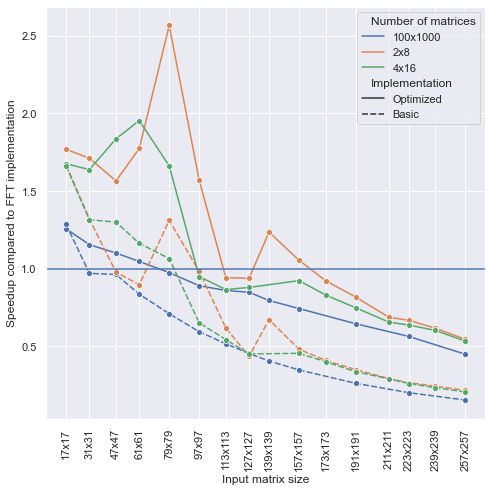

In [123]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark1 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution_gpulab")
group1 = benchmark1.groups["n_to_mn_anti_fft"]

benchmark2 = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_resolution2_gpulab")
group2 = benchmark2.groups["n_to_mn_anti_fft"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data1 = pd.concat([run.data for run in group1.runs], axis=0, ignore_index=True)
data2 = pd.concat([run.data for run in group2.runs], axis=0, ignore_index=True)


data = pd.concat([
    data1[~(data1["Input type"].isin(["2x4", "2x8", "4x8", "4x16"]))],
    data2
], axis=0, ignore_index=True)

data = data[(data["Input matrix rows"] <= 257) & (~data["Input type"].isin(["2x4", "4x8"]))]

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input type": "Number of matrices"}, inplace=True)


sns.set(rc={'figure.figsize': (7, 7)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_speedup_n_to_mn_anti_fft_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP N TO M

In [124]:

fig.savefig("fft_speedup_n_to_m_gpulab.svg", format="svg")

# GPULAB FFT SPEEDUP N TO M ANTIFFT

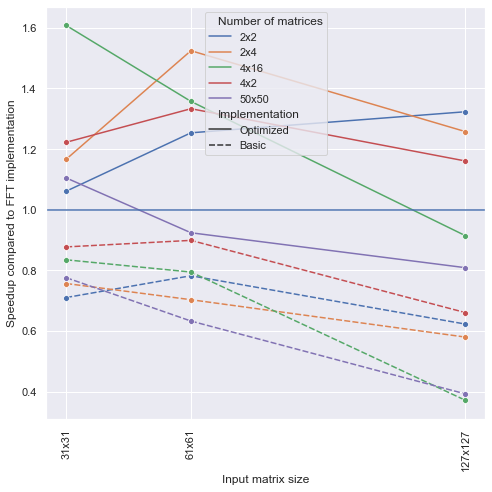

In [125]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "definition_based_optimization_speedup_compute_gpulab")

group = benchmark.groups["n_to_m_anti_fft"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)
data = data[data["Input matrix rows"] <= 256]

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]



results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()

results.rename(columns={"Input type": "Number of matrices"}, inplace=True)

sns.set(rc={'figure.figsize': (7, 7)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_speedup_n_to_m_anti_fft_gpulab.svg", format="svg")

# GPULAB FFT STARTUP ONE TO MANY

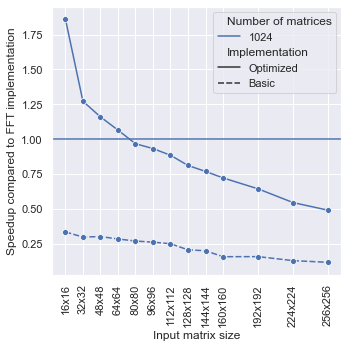

In [126]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_startup_resolution_gpulab")

group = benchmark.groups["one_to_many"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

data = data[(data["Input matrix rows"] <= 260) & (data["Input right matrices"] == 1024)]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]


results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input right matrices"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input right matrices": "Number of matrices"}, inplace=True)

palette = dict(zip(results["Number of matrices"].unique(), sns.color_palette(n_colors=results["Number of matrices"].nunique())))

sns.set(rc={'figure.figsize': (5, 5)})

fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', palette=palette, ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_startup_one_to_many_gpulab.svg", format="svg")

# GPULAB FFT STARTUP ONE TO MANY ANTI FFT

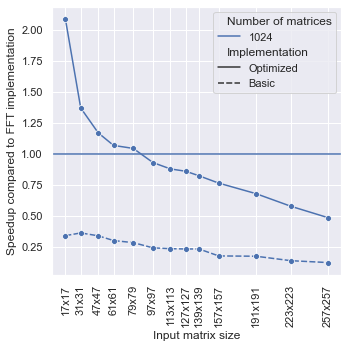

In [127]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_startup_resolution_gpulab")

group = benchmark.groups["one_to_many_anti_fft"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]


results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input right matrices"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input right matrices": "Number of matrices"}, inplace=True)

palette = dict(zip(results["Number of matrices"].unique(), sns.color_palette(n_colors=results["Number of matrices"].nunique())))

sns.set(rc={'figure.figsize': (5, 5)})

fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', palette=palette, ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_startup_one_to_many_antifft_gpulab.svg", format="svg")

# GPULAB FFT STARTUP N TO MN

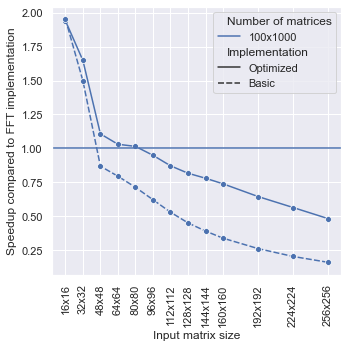

In [128]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_startup_resolution_gpulab")

group = benchmark.groups["n_to_mn"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)


grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input type": "Number of matrices"}, inplace=True)

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_startup_n_to_mn_gpulab.svg", format="svg")

# GPULAB FFT STARTUP N TO MN ANTIFFT

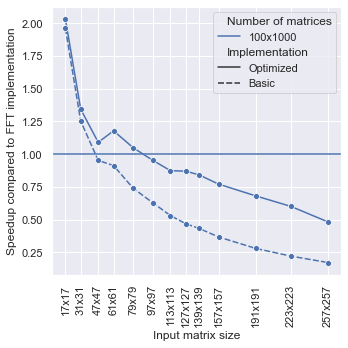

In [129]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_startup_resolution_gpulab")

group = benchmark.groups["n_to_mn_anti_fft"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)


grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input type": "Number of matrices"}, inplace=True)

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_startup_n_to_mn_antifft_gpulab.svg", format="svg")

# GPULAB FFT STARTUP N TO M

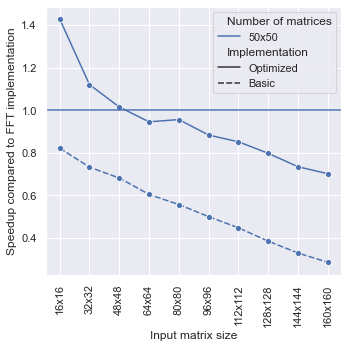

In [134]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_startup_resolution_gpulab")

group = benchmark.groups["n_to_m"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)


grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

cols = ["Input type", "Input matrix rows"]
results = results[results[cols].apply(tuple, axis=1).isin(comparison_base_times[cols].apply(tuple, axis=1))]


def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]



results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input type": "Number of matrices"}, inplace=True)

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_startup_n_to_m_gpulab.svg", format="svg")

# GPULAB FFT STARTUP N TO M ANTIFFT

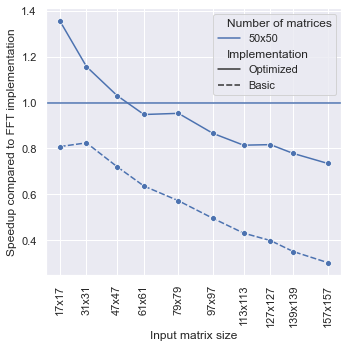

In [133]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "fft_speedup_compute_startup_resolution_gpulab")

group = benchmark.groups["n_to_m_anti_fft"]

comparison_base_name = "fft_orig"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

cols = ["Input type", "Input matrix rows"]
results = results[results[cols].apply(tuple, axis=1).isin(comparison_base_times[cols].apply(tuple, axis=1))]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]



results["Speedup"] = results.apply(speedup, axis=1)

basic_results = results[results["Name"] == "basic"].copy()
basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

results = pd.concat([basic_results, thesis_results]).reset_index()
results.rename(columns={"Input type": "Number of matrices"}, inplace=True)

sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", style="Implementation", style_order=["Optimized", "Basic"], marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to FFT implementation")
ax.axhline(1)
fig.tight_layout()
fig.savefig("fft_startup_n_to_m_antifft_gpulab.svg", format="svg")

# GPULAB SCIPY ONE TO ONE

   Input matrix rows     Speedup Implementation
0                  8    0.172511      Optimized
1                 16    2.039236      Optimized
2                 24    9.069348      Optimized
3                 32   35.521336      Optimized
4                 40   80.448984      Optimized
5                 48  150.588428      Optimized
6                 56  270.348935      Optimized
7                 64  408.160158      Optimized
                                            Name Args  Input matrix rows  \
17  nai_shuffle_multimat_right_work_distribution                      16   
20  nai_shuffle_multimat_right_work_distribution                      40   
22  nai_shuffle_multimat_right_work_distribution                      56   
32                     nai_shuffle_multirow_both    8                  8   
34                     nai_shuffle_multirow_both    8                 24   
43                            nai_warp_per_shift                      32   
45                            nai_wa

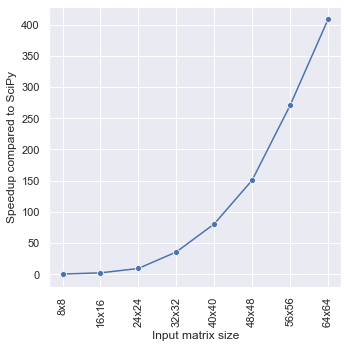

In [135]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "scipy_speedup_gpulab")

group = benchmark.groups["one_to_one"]

comparison_base_name = "scipy"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

grouped = data.groupby(["Name", "Args", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]



def speedup(row):
    min_time = comparison_base_times[comparison_base_times["Input matrix rows"] == row["Input matrix rows"]]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)

# basic_results = results[results["Name"] == "basic"].copy()
# basic_results["Implementation"] = "Basic"

thesis_results = results[~results["Name"].isin(["fft_orig", "basic", "scipy"])].groupby(["Input matrix rows"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

print(thesis_results)

print(results[results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1).isin(thesis_results[["Speedup", "Input matrix rows"]].apply(tuple, axis=1))])
print(results[results["Name"] == "scipy"][["Input matrix rows", "Computation time"]])
# results = pd.concat([basic_results, thesis_results]).reset_index()
results = thesis_results.reset_index()



sns.set(rc={'figure.figsize': (5, 5)})
fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to SciPy")
fig.tight_layout()
fig.savefig("scipy_one_to_one_gpulab.svg", format="svg")

# SCIPY ONE TO MANY

                                             Name Args  Input right matrices  \
64   nai_shuffle_multimat_right_work_distribution                          2   
65   nai_shuffle_multimat_right_work_distribution                          2   
66   nai_shuffle_multimat_right_work_distribution                          2   
67   nai_shuffle_multimat_right_work_distribution                          2   
68   nai_shuffle_multimat_right_work_distribution                          2   
69   nai_shuffle_multimat_right_work_distribution                          2   
70   nai_shuffle_multimat_right_work_distribution                          2   
71   nai_shuffle_multimat_right_work_distribution                          2   
73   nai_shuffle_multimat_right_work_distribution                          4   
74   nai_shuffle_multimat_right_work_distribution                          4   
75   nai_shuffle_multimat_right_work_distribution                          4   
76   nai_shuffle_multimat_right_work_dis

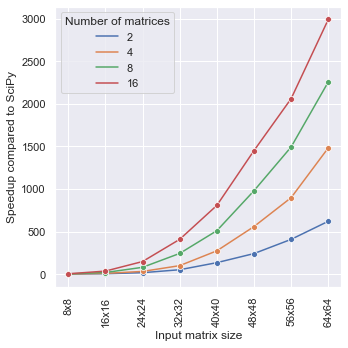

In [136]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "scipy_speedup_gpulab")
group = benchmark.groups["one_to_many"]


comparison_base_name = "scipy"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)

#data = data[data["Input right matrices"] >= 8]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)
# basic_results = results[results["Name"] == "basic"].copy()
# basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic", "scipy"])].groupby(["Input matrix rows", "Input right matrices"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

print(results[results[["Speedup", "Input matrix rows", "Input right matrices"]].apply(tuple, axis=1).isin(thesis_results[["Speedup", "Input matrix rows", "Input right matrices"]].apply(tuple, axis=1))])
print(results[results["Name"] == "scipy"][["Input matrix rows", "Input right matrices", "Computation time"]])

#results = pd.concat([basic_results, thesis_results]).reset_index()
results = thesis_results.reset_index()
results.rename(columns={"Input right matrices": "Number of matrices"}, inplace=True)
palette = dict(zip(results["Number of matrices"].unique(), sns.color_palette(n_colors=results["Number of matrices"].nunique())))


sns.set(rc={'figure.figsize': (5, 5)})

fig, ax = plt.subplots()

ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", marker='o', palette=palette, ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to SciPy")
fig.tight_layout()
fig.savefig("scipy_one_to_many_gpulab.svg", format="svg")

# SCIPY N TO MN

                                             Name Args Input type  \
64   nai_shuffle_multimat_right_work_distribution             2x4   
65   nai_shuffle_multimat_right_work_distribution             2x4   
66   nai_shuffle_multimat_right_work_distribution             2x4   
71   nai_shuffle_multimat_right_work_distribution             2x4   
77   nai_shuffle_multimat_right_work_distribution             2x8   
78   nai_shuffle_multimat_right_work_distribution             2x8   
79   nai_shuffle_multimat_right_work_distribution             2x8   
80   nai_shuffle_multimat_right_work_distribution            4x16   
81   nai_shuffle_multimat_right_work_distribution            4x16   
82   nai_shuffle_multimat_right_work_distribution            4x16   
84   nai_shuffle_multimat_right_work_distribution            4x16   
85   nai_shuffle_multimat_right_work_distribution            4x16   
86   nai_shuffle_multimat_right_work_distribution            4x16   
87   nai_shuffle_multimat_right_wo

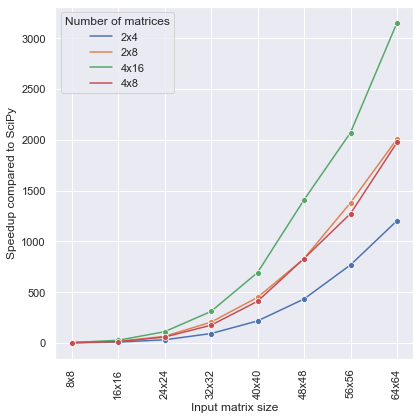

In [137]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "scipy_speedup_gpulab")
group = benchmark.groups["n_to_mn"]

comparison_base_name = "scipy"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)


#data = data[~(data["Input type"].isin(["2x4", "4x8"]))]

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]

results["Speedup"] = results.apply(speedup, axis=1)

# basic_results = results[results["Name"] == "basic"].copy()
# basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic", "scipy"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

print(results[results[["Speedup", "Input matrix rows", "Input type"]].apply(tuple, axis=1).isin(thesis_results[["Speedup", "Input matrix rows", "Input type"]].apply(tuple, axis=1))])
print(results[results["Name"] == "scipy"][["Input matrix rows", "Input type", "Computation time"]])


# results = pd.concat([basic_results, thesis_results]).reset_index()
results = thesis_results.reset_index()

results.rename(columns={"Input type": "Number of matrices"}, inplace=True)


sns.set(rc={'figure.figsize': (6, 6)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to SciPy")
fig.tight_layout()
fig.savefig("scipy_n_to_mn_gpulab.svg", format="svg")

# SCIPY N TO M

                                            Name Args Input type  \
48   nai_shuffle_multimat_both_work_distribution             4x4   
49   nai_shuffle_multimat_both_work_distribution             4x4   
50   nai_shuffle_multimat_both_work_distribution             4x4   
51   nai_shuffle_multimat_both_work_distribution             4x4   
52   nai_shuffle_multimat_both_work_distribution             4x4   
53   nai_shuffle_multimat_both_work_distribution             4x4   
54   nai_shuffle_multimat_both_work_distribution             4x4   
56   nai_shuffle_multimat_both_work_distribution             4x8   
57   nai_shuffle_multimat_both_work_distribution             4x8   
58   nai_shuffle_multimat_both_work_distribution             4x8   
59   nai_shuffle_multimat_both_work_distribution             4x8   
60   nai_shuffle_multimat_both_work_distribution             4x8   
61   nai_shuffle_multimat_both_work_distribution             4x8   
62   nai_shuffle_multimat_both_work_distribution

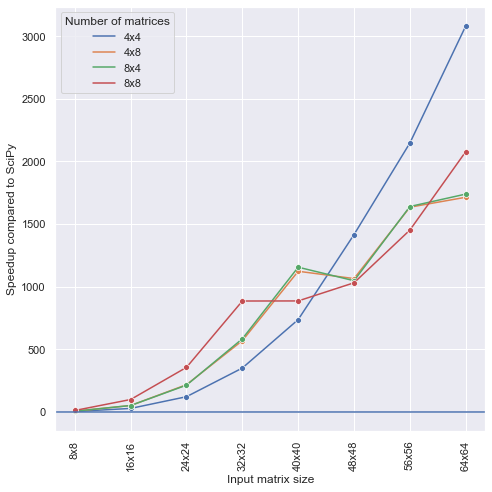

In [138]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "scipy_speedup_gpulab")

group = benchmark.groups["n_to_m"]

comparison_base_name = "scipy"
comparison_base_args = ""

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)
# data = data[data["Input matrix rows"] <= 256]

grouped = data.groupby(["Name", "Args", "Input type", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input type"] == row["Input type"]) & (comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]



results["Speedup"] = results.apply(speedup, axis=1)

# basic_results = results[results["Name"] == "basic"].copy()
# basic_results["Implementation"] = "Basic"
thesis_results = results[~results["Name"].isin(["fft_orig", "basic", "scipy"])].groupby(["Input matrix rows", "Input type"])["Speedup"].max().to_frame().reset_index()
thesis_results["Implementation"] = "Optimized"

print(results[results[["Speedup", "Input matrix rows", "Input type"]].apply(tuple, axis=1).isin(thesis_results[["Speedup", "Input matrix rows", "Input type"]].apply(tuple, axis=1))])
print(results[results["Name"] == "scipy"][["Input matrix rows", "Input type", "Computation time"]])



# results = pd.concat([basic_results, thesis_results]).reset_index()
results = thesis_results.reset_index()
results.rename(columns={"Input type": "Number of matrices"}, inplace=True)


sns.set(rc={'figure.figsize': (7, 7)})
fig, ax = plt.subplots()
ax = sns.lineplot(data=results, x="Input matrix rows", y="Speedup", hue="Number of matrices", marker='o', ax=ax)
ax.set_xticks(results["Input matrix rows"].unique())
ticks = ax.get_xticks()
ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlabel("Input matrix size")
ax.set_ylabel(f"Speedup compared to SciPy")
ax.axhline(1)
fig.tight_layout()
fig.savefig("scipy_n_to_m_gpulab.svg", format="svg")